In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

#Load data
df = pd.read_csv(r'C:\Users\Kerry\Breast_cancer_dataset.csv')

#Clean data
if 'Unnamed: 32' in df.columns:
    df = df.drop(columns=['Unnamed: 32'])

label_enc = LabelEncoder()
df['diagnosis_encoded'] = label_enc.fit_transform(df['diagnosis'])  # M=1, B=0


### Basic EDA

Dataset shape: (569, 33)
Class distribution:
 diagnosis
B    357
M    212
Name: count, dtype: int64


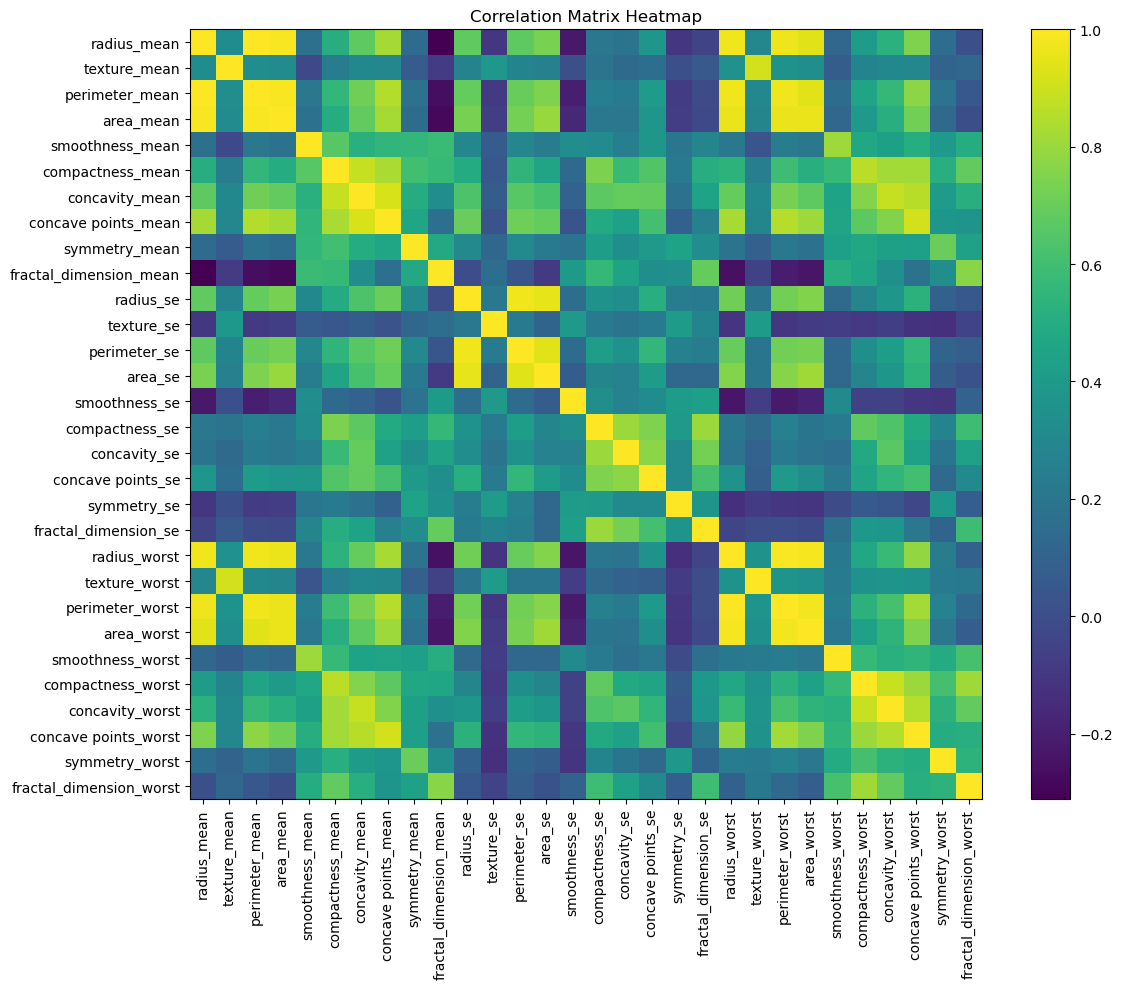

ValueError: could not convert string to float: 'M'

In [2]:

print("Dataset shape:", df.shape)
print("Class distribution:\n", df['diagnosis'].value_counts())

# Correlation
numeric_features = df.select_dtypes(include=[np.number]).drop(columns=['id','diagnosis_encoded'])
corr_matrix = numeric_features.corr()

plt.figure(figsize=(12,10))
plt.imshow(corr_matrix, aspect='auto')
plt.colorbar()
plt.title("Correlation Matrix Heatmap")
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.tight_layout()
plt.show()

# Target correlation
target_corr = df.corr()['diagnosis_encoded'].abs().sort_values(ascending=False)
top_features = target_corr.index[1:4]  # top 3 correlated predictors
print("Top features correlated with diagnosis:", top_features.tolist())

for feat in top_features:
    plt.figure()
    plt.scatter(df[feat], df['diagnosis_encoded'], alpha=0.5)
    plt.title(f"{feat} vs Diagnosis")
    plt.xlabel(feat)
    plt.ylabel("Diagnosis (encoded)")
    plt.yticks([0,1], label_enc.inverse_transform([0,1]))
    plt.tight_layout()
    plt.show()


### Modeling preparation

In [3]:

X = df.drop(columns=['id','diagnosis','diagnosis_encoded'])
y = df['diagnosis_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, X.columns)
])

models = {
    'LogisticRegression': LogisticRegression(max_iter=5000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'SVC': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=42)
}

cv_results = {}
for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')
    cv_results[name] = scores
    print(f"{name} CV accuracy: mean={scores.mean():.4f}, std={scores.std():.4f}")

# Pick best model
best_name = max(cv_results, key=lambda k: cv_results[k].mean())
print(f"Best model based on CV: {best_name}")

# Hyperparameter tuning if best is RandomForest
if best_name == 'RandomForest':
    base_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                                ('model', RandomForestClassifier(random_state=42))])
    param_grid = {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 5, 10],
        'model__min_samples_split': [2, 5]
    }
    grid = GridSearchCV(base_pipe, param_grid, cv=5, scoring='accuracy')
    grid.fit(X_train, y_train)
    best_pipe = grid.best_estimator_
    print("Best RandomForest params:", grid.best_params_)
else:
    best_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', models[best_name])])
    best_pipe.fit(X_train, y_train)


LogisticRegression CV accuracy: mean=0.9714, std=0.0112
RandomForest CV accuracy: mean=0.9626, std=0.0338
SVC CV accuracy: mean=0.9736, std=0.0132
KNN CV accuracy: mean=0.9626, std=0.0226
DecisionTree CV accuracy: mean=0.9319, std=0.0281
Best model based on CV: SVC


### Evaluation


Classification Report:
              precision    recall  f1-score   support

           B       0.96      1.00      0.98        72
           M       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114

Confusion Matrix:
 [[72  0]
 [ 3 39]]


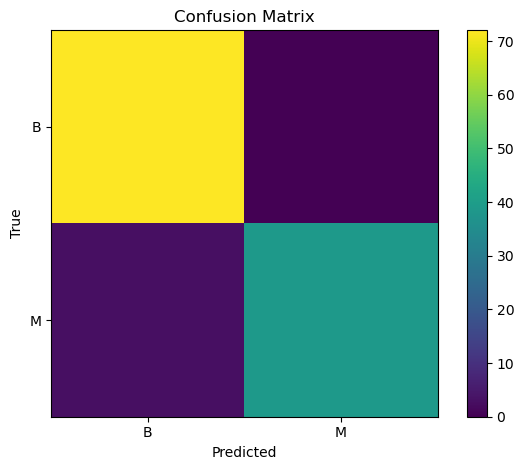

<Figure size 640x480 with 0 Axes>

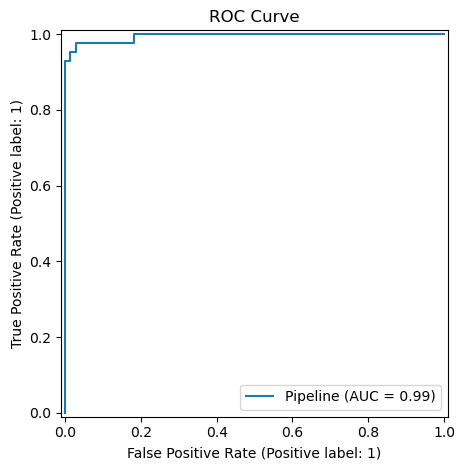

<Figure size 640x480 with 0 Axes>

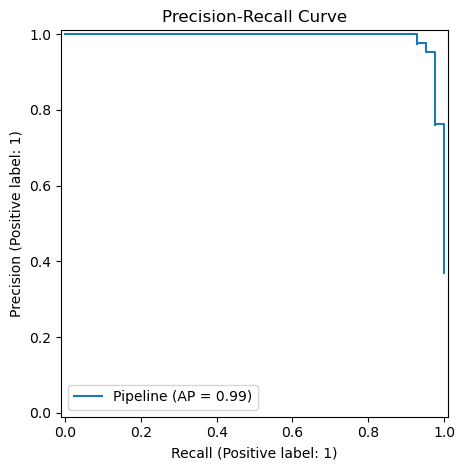

In [4]:

y_pred = best_pipe.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_enc.inverse_transform([0,1])))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0,1], label_enc.inverse_transform([0,1]))
plt.yticks([0,1], label_enc.inverse_transform([0,1]))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

plt.figure()
RocCurveDisplay.from_estimator(best_pipe, X_test, y_test)
plt.title("ROC Curve")
plt.tight_layout()
plt.show()

plt.figure()
PrecisionRecallDisplay.from_estimator(best_pipe, X_test, y_test)
plt.title("Precision-Recall Curve")
plt.tight_layout()
plt.show()

# Feature importance for tree models
model = best_pipe.named_steps['model']
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    feature_names = X.columns
    idx = np.argsort(importances)[::-1][:10]
    plt.figure()
    plt.bar(range(len(idx)), importances[idx])
    plt.xticks(range(len(idx)), feature_names[idx], rotation=90)
    plt.title("Top 10 Feature Importances")
    plt.tight_layout()
    plt.show()